In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from test_model import make_sin_data, LnLikelihood, LnPrior
from impulse.base import TestSampler

import matplotlib.pyplot as plt

import corner

In [2]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

In [3]:
lnlike = LnLikelihood(x, data)
lnprior = LnPrior([0, 0, 0], [3, 5, np.pi])

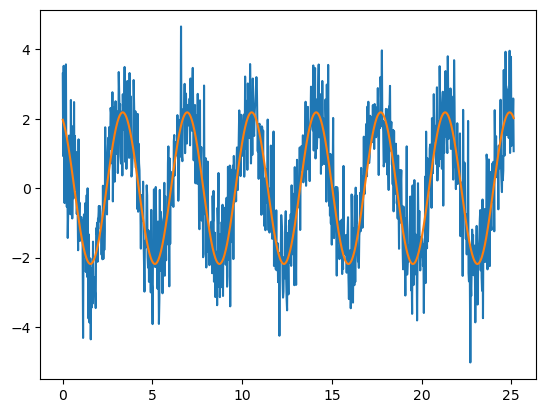

In [4]:
plt.plot(x, data)
plt.plot(x, a_real * np.sin(omega_real*x + phi_real))

In [5]:
sampler = TestSampler(3, lnlike, lnprior, cov_update=100)

In [6]:
sampler.sample(np.array([2, 3, 1]), 100_000, thin=1)

100%|██████████| 99999/99999 [00:10<00:00, 9328.51it/s]


In [7]:
from emcee.autocorr import integrated_time

In [8]:
with open('./chains/chain_1.txt', 'r') as f:
    chain = np.loadtxt(f)

In [9]:
integrated_time(chain[20_000:, 2])

array([15.26366505])

In [10]:
print(omega_real, a_real, phi_real)

1.7478834386272433 2.1847429416884467 2.0164158613853576


(-1.0, 1.0)

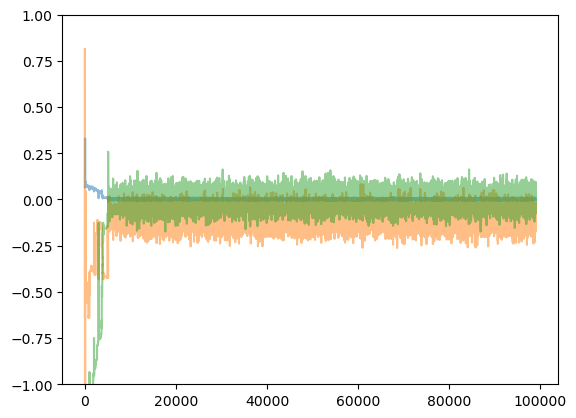

In [11]:
plt.plot(chain[:, 0] - omega_real, alpha = 0.5)
plt.plot(chain[:, 1] - a_real, alpha = 0.5)
plt.plot(chain[:, 2] - phi_real, alpha = 0.5)
plt.ylim([-1, 1])

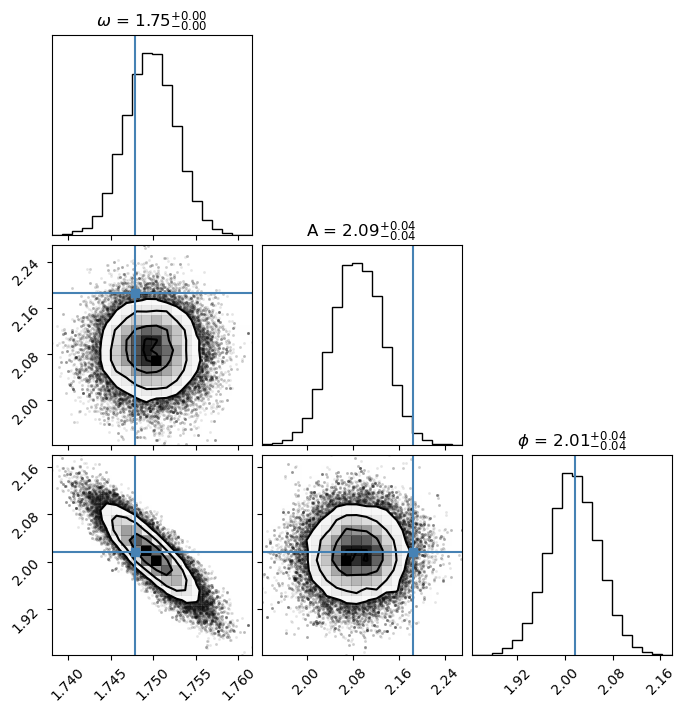

In [12]:
burn = 20_000

corner.corner(chain[burn::1, :3], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()

In [14]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [15]:
sampler = ptmcmc(3, lnlike, lnprior, cov=np.eye(3), outDir='./sine_chains')

In [42]:
sampler.sample(np.array([2., 3., 1.]), Niter=100_000, thin=1, SCAMweight=30, AMweight=15, DEweight=50)

Finished 10.00 percent in 0.799068 s Acceptance rate = 0.34677Adding DE jump with weight 50
Finished 99.00 percent in 7.817213 s Acceptance rate = 0.205192
Run Complete


In [43]:
with open('./sine_chains/chain_1.txt', 'r') as fp:
    chain = np.loadtxt(fp)

In [44]:
chain.shape

(99000, 7)

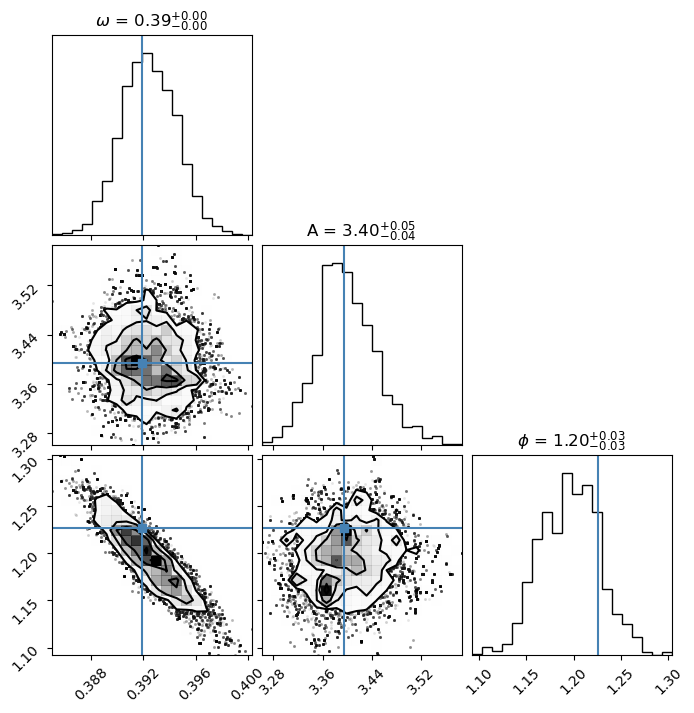

In [45]:
corner.corner(chain[20_000:, :-4],truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True);

(-1.0, 1.0)

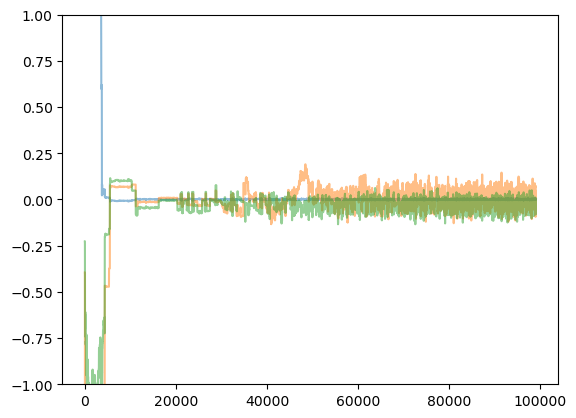

In [46]:
plt.plot(chain[:, 0] - omega_real, alpha = 0.5)
plt.plot(chain[:, 1] - a_real, alpha = 0.5)
plt.plot(chain[:, 2] - phi_real, alpha = 0.5)
plt.ylim([-1, 1])

In [47]:
integrated_time(chain[20_000:, 1])

array([1186.18110085])